In [1]:
#essential imports
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize

#scraping imports
import requests
from bs4 import BeautifulSoup

#plotting imports
%matplotlib inline
import matplotlib.pyplot as plt

## 1.  Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).

Using the postman plugin on google chrome, we found the json representing the list of the universities:

https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508252855868

We want to scrap those data from the site:
* name 
* rank
* country
* region 
* number of faculty members (international and total)
* number of students (international and total)

In the JSON we retrieved, there is already the **name**, **rank**, **country** and **region**. 

In [2]:
#json to dataframe using panda
json_data = json.load(open('TopUniRanking.json'))
df = json_normalize(json_data['data'])
#the university are sorted by ranks, so we just need the 200 first indexes
dfTopUni200 = df.head(200)
#drop useless column information
dfTopUni200 = dfTopUni200.drop(["cc","core_id","logo","guide"],axis=1)
dfTopUni200.head(10)

country     nid rank_display         region score stars  \
0   United States  294850            1  North America   100     6   
1   United States  297282            2  North America  98.7     5   
2   United States  294270            3  North America  98.4     5   
3   United States  294562            4  North America  97.7     5   
4  United Kingdom  294561            5         Europe  95.6     5   
5  United Kingdom  294654            6         Europe  95.3     5   
6  United Kingdom  294014            7         Europe  94.6  None   
7  United Kingdom  294030            8         Europe  93.7  None   
8   United States  294536            9  North America  93.5     5   
9     Switzerland  294432           10         Europe  93.3  None   

                                               title  \
0        Massachusetts Institute of Technology (MIT)   
1                                Stanford University   
2                                 Harvard University   
3       California Institute of Technology (Caltech)   
4                            University of Cambridge   
5                               University of Oxford   
6                    UCL (University College London)   
7                            Imperial College London   
8                              University of Chicago   
9  ETH Zurich - Swiss Federal Institute of Techno...   

                                                 url  
0  /universities/massachusetts-institute-technolo...  
1                  /universities/stanford-university  
2                   /universities/harvard-university  
3  /universities/california-institute-technology-...  
4                 /universities/university-cambridge  
5                    /universities/university-oxford  
6        /universities/ucl-university-college-london  
7              /universities/imperial-college-london  
8                   /universities/university-chicago  
9  /universities/eth-zurich-swiss-federal-institu...

We now have the general data for the 200 first universities. Then we need to scrap data on each unique page of each university to retrieve those 4 informations: 
* **number of total faculty members** 
* **number of international faculty members**
* **number of total students** 
* **number of international students**

The url of each university is contained in our previous dataFrame. And the link to the pages are written this way:
 **https://www.topuniversities.com+url** 
 
Using developper tool in google chrome, we found that the 4 datas we want are located inside unique html objects that have as class: **total faculty**, **inter faculty**, **total student** and **total inter**.
So to find those datas we filter by class name the html page, then we retreive the specific associated information.

### **Warning :** the next cell requiers internet to work as intended and it lasts around 2 minutes of computation.


In [3]:
listUrl = dfTopUni200['url']
#create a temporary dataframe
index = range(200)
columns = ["nbr_faculty_members","nbr_international_faculty_members","nbr_total_students","nbr_international_total_students"]
temp_df = pd.DataFrame(index=index,columns=columns)

#helper function that filter the html file and return the int corresponding to the special string htmlClass
#return NaN if the object doesn't exist
def findNumberOf(soup,htmlClass):
    filteredHtmlElements = soup.find_all('div', class_=htmlClass)
    #case if a field information is not given
    if(len(filteredHtmlElements)==0):
        return np.nan
    #find the integer value inside the html balise
    t= filteredHtmlElements[0].find('div', class_='number').text
    #clear the input then convert it into an integer
    return int(t.replace('\n', '').replace('\r', '').replace(',', '').replace(' ',''))

#retrieve the 4 informations needed from the url, for each university
for i,url in enumerate(listUrl):
    finalUrl = "https://www.topuniversities.com"+url
    r = requests.get(finalUrl)
    soup = BeautifulSoup(r.text, 'html.parser')
    #todo: scrap with beautifulSoup using the url
    #merge data into the temp dataframe
    temp_df.nbr_faculty_members[i] = findNumberOf(soup,'total faculty')
    temp_df.nbr_international_faculty_members[i] = findNumberOf(soup,'inter faculty')
    temp_df.nbr_total_students[i] = findNumberOf(soup,'total student')
    temp_df.nbr_international_total_students[i] = findNumberOf(soup,'total inter')

Now that we have all the informations we want into this DataFrame, we merge it with the initial one.

In [4]:
#merge the old dataframe with the new information
#fullDataFrameTopUni200 contains all the information of the 200 top universities from www.topuniversities.com
fullDataFrameTopUni200 = dfTopUni200.join(temp_df)
fullDataFrameTopUni200.head(10)

country     nid rank_display         region score stars  \
0   United States  294850            1  North America   100     6   
1   United States  297282            2  North America  98.7     5   
2   United States  294270            3  North America  98.4     5   
3   United States  294562            4  North America  97.7     5   
4  United Kingdom  294561            5         Europe  95.6     5   
5  United Kingdom  294654            6         Europe  95.3     5   
6  United Kingdom  294014            7         Europe  94.6  None   
7  United Kingdom  294030            8         Europe  93.7  None   
8   United States  294536            9  North America  93.5     5   
9     Switzerland  294432           10         Europe  93.3  None   

                                               title  \
0        Massachusetts Institute of Technology (MIT)   
1                                Stanford University   
2                                 Harvard University   
3       California Institute of Technology (Caltech)   
4                            University of Cambridge   
5                               University of Oxford   
6                    UCL (University College London)   
7                            Imperial College London   
8                              University of Chicago   
9  ETH Zurich - Swiss Federal Institute of Techno...   

                                                 url nbr_faculty_members  \
0  /universities/massachusetts-institute-technolo...                2982   
1                  /universities/stanford-university                4285   
2                   /universities/harvard-university                4350   
3  /universities/california-institute-technology-...                 953   
4                 /universities/university-cambridge                5490   
5                    /universities/university-oxford                6750   
6        /universities/ucl-university-college-london                6345   
7              /universities/imperial-college-london                3930   
8                   /universities/university-chicago                2449   
9  /universities/eth-zurich-swiss-federal-institu...                2477   

  nbr_international_faculty_members nbr_total_students  \
0                              1679              11067   
1                              2042              15878   
2                              1311              22429   
3                               350               2255   
4                              2278              18770   
5                              2964              19720   
6                              2554              31080   
7                              2071              16090   
8                               635              13557   
9                              1886              19815   

  nbr_international_total_students  
0                             3717  
1                             3611  
2                             5266  
3                              647  
4                             6699  
5                             7353  
6                            14854  
7                             8746  
8                             3379  
9                             7563

## Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

To answer this question we use the previous DataFrame filtering only interesting parameters in column.
Then we can compute the 2 ratios.

Take note that we drop 2 university that doesn't provide enough information on their personnal page.
Indian Institute of Science (IISc) Bangalore doesn't have the number of international faculty member and New York University (NYU) doesn't have any data at all!

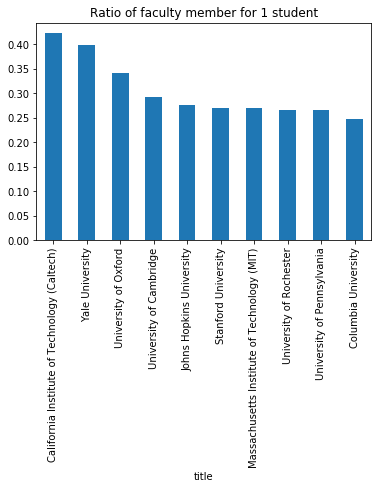

In [13]:
#helper function that compute the ratio of faculty member in function of students
def percentFacAndStud (row):
    return row['nbr_faculty_members']/row['nbr_total_students']
#helper function that compute the ratio of international students in function of total students
def percentInterAndStud (row):
    return row['nbr_international_total_students']/row['nbr_total_students']


#hard copy old DF and drop university that doesn't have the infromation required
filteredDataFrame = fullDataFrameTopUni200.copy()[['title','nbr_faculty_members','nbr_international_faculty_members','nbr_total_students','nbr_international_total_students']].dropna()

#create new row with the function percentFacAndStud to compute the ratio faculty member per student
filteredDataFrame['ratio_faculty_per_student'] = filteredDataFrame.apply (lambda row: percentFacAndStud (row),axis=1)
#create new row with the function percentInterAndStud to compute the ratio international students in function of total students
filteredDataFrame['ratio_international_students'] = filteredDataFrame.apply (lambda row: percentInterAndStud (row),axis=1)

#filter the result to answer question (a)
resultDataFrame=filteredDataFrame[['title','ratio_faculty_per_student','nbr_faculty_members','nbr_total_students']]
#return the head of the dataframe, sorted by best ratio faculty per student
topRatioFacPerStudent = resultDataFrame.sort_values(by='ratio_faculty_per_student',ascending=False).head(10)

#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent.set_index('title')['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

The top 3 universities in term of **ratio between faculty members and students** are : 
* California Institute of Technology (Caltech)
* Yale University
* University of Oxford



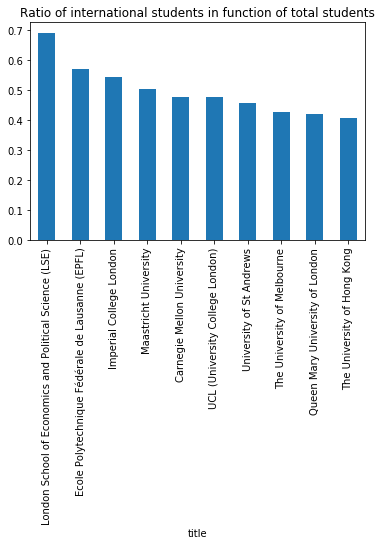

In [17]:
#filter the result to answer question (b)
resultDataFrame=filteredDataFrame[['title','ratio_international_students','nbr_international_total_students','nbr_total_students']]
#return the head of the dataframe, sorted by best ratio faculty per student
topRatioInterStudents = resultDataFrame.sort_values(by='ratio_international_students',ascending=False).head(10)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents.set_index('title')['ratio_international_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

The top 3 universities in term of **ratio of international students** are:
* London School of Economics and Political Science
* **Ecole Polytechnique Fédérale de Lausanne (EPFL)**	
* Imperial College London

## Answer the previous question aggregating the data by (c) country and (d) region.

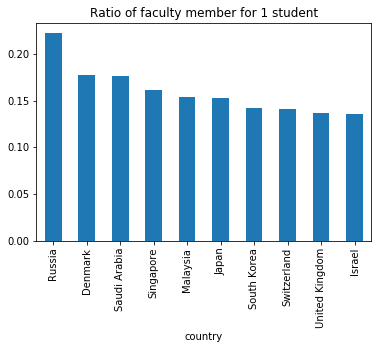

In [22]:
#filter the full dataFrame to only releveant parameters
filteredDataFrame = fullDataFrameTopUni200.copy()[['country','region','nbr_faculty_members','nbr_international_faculty_members','nbr_total_students','nbr_international_total_students']]
#aggregate the countries for question (c)
countryDataFrame = filteredDataFrame.drop('region',axis=1).groupby('country').agg('sum')

#the same helper functions are applied to create the 2 ratio into 2 new columns
countryDataFrame['ratio_faculty_per_student'] = countryDataFrame.apply (lambda row: percentFacAndStud (row),axis=1)
countryDataFrame['ratio_international_students'] = countryDataFrame.apply (lambda row: percentInterAndStud (row),axis=1)

topRatioFacPerStudent = countryDataFrame[['ratio_faculty_per_student','nbr_faculty_members','nbr_total_students']].sort_values(by='ratio_faculty_per_student',ascending=False).head(10)
#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

The top 3 countries in term of **ratio between faculty members and students** are:
* Russia
* Denmark
* Saudia Arabia

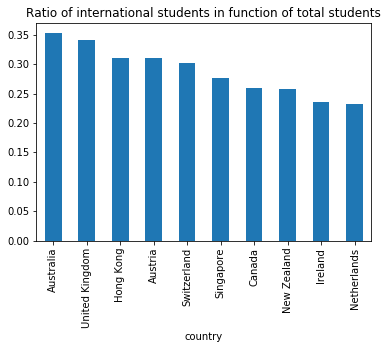

In [23]:
topRatioInterStudents = countryDataFrame[['ratio_international_students','nbr_international_total_students','nbr_total_students']].sort_values(by='ratio_international_students',ascending=False).head(10)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents['ratio_international_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

The top 3 countries in term of **ratio of international students** are:
* Australia
* United Kingdom	
* Hong Kong

## Answer the previous question for region. (d)

This code is similar to the code of question (c), but instead we aggregate on the label 'region' instead of 'country'.

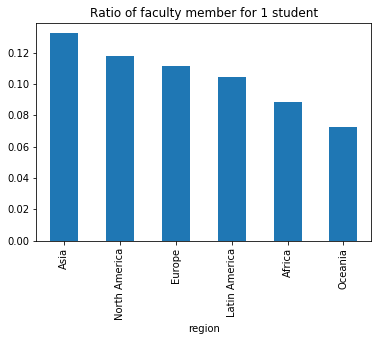

In [25]:
# same code as for the country, but with region
regionDataFrame = filteredDataFrame.drop('country',axis=1).groupby('region').agg('sum')

#the same helper functions are applied to create the 2 ratio into 2 new columns
regionDataFrame['ratio_faculty_per_student'] = regionDataFrame.apply (lambda row: percentFacAndStud (row),axis=1)
regionDataFrame['ratio_international_students'] = regionDataFrame.apply (lambda row: percentInterAndStud (row),axis=1)
topRatioFacPerStudent = regionDataFrame[['ratio_faculty_per_student','nbr_faculty_members','nbr_total_students']].sort_values(by='ratio_faculty_per_student',ascending=False)
#plot them in a pie chart:
topRatioFacPerStudent = topRatioFacPerStudent['ratio_faculty_per_student']
topRatioFacPerStudent.plot(kind='bar', title='Ratio of faculty member for 1 student')
plt.show()

The top 3 regions in term of **ratio between faculty members and students** are:
* Asia
* North America
* Europe

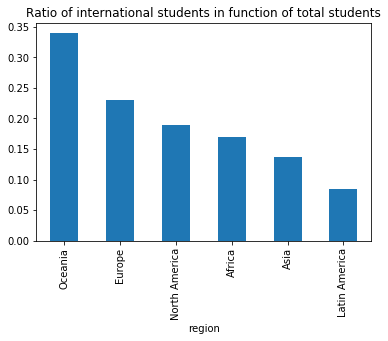

In [27]:
topRatioInterStudents = regionDataFrame[['ratio_international_students','nbr_international_total_students','nbr_total_students']].sort_values(by='ratio_international_students',ascending=False)
#plot them in a pie chart:
topRatioInterStudents = topRatioInterStudents['ratio_international_students']
topRatioInterStudents.plot(kind='bar', title='Ratio of international students in function of total students')
plt.show()

The top 3 regions in term of **ratio of international students** are:
* Oceania
* Europe
* North America

# 2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

Again using the postman plugin on google chrome, we found the json representing the list of the universities:


https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json

In [29]:
#json to dataframe using panda
json_data2 = json.load(open('TimesRanking.json'))
df2 = json_normalize(json_data2['data'])
#print(df2.T.index)
fullDataFrameTimes200 = df2.head(200)
fullDataFrameTimes200.head(4)

aliases        location member_level  \
0                        University of Oxford  United Kingdom            0   
1                     University of Cambridge  United Kingdom            0   
2  California Institute of Technology caltech   United States            0   
3                         Stanford University   United States           11   

                                 name     nid rank rank_order     record_type  \
0                University of Oxford     468    1         10  master_account   
1             University of Cambridge     470    2         20  master_account   
2  California Institute of Technology  128779   =3         30         private   
3                 Stanford University     467   =3         40         private   

  scores_citations scores_citations_rank  \
0             99.1                    15   
1             97.5                    29   
2             99.5                    10   
3             99.9                     4   

                         ...                         scores_research  \
0                        ...                                    99.5   
1                        ...                                    97.8   
2                        ...                                    97.5   
3                        ...                                    96.7   

  scores_research_rank scores_teaching scores_teaching_rank  \
0                    1            86.7                    5   
1                    3            87.8                    3   
2                    4            90.3                    1   
3                    5            89.1                    2   

  stats_female_male_ratio stats_number_students stats_pc_intl_students  \
0                 46 : 54                20,409                    38%   
1                 45 : 55                18,389                    35%   
2                 31 : 69                 2,209                    27%   
3                 42 : 58                15,845                    22%   

  stats_student_staff_ratio  \
0                      11.2   
1                      10.9   
2                       6.5   
3                       7.5   

                                    subjects_offered  \
0  Archaeology,Art, Performing Arts & Design,Biol...   
1  Archaeology,Architecture,Art, Performing Arts ...   
2  Architecture,Biological Sciences,Business & Ma...   
3  Archaeology,Architecture,Art, Performing Arts ...   

                                                 url  
0       /world-university-rankings/university-oxford  
1    /world-university-rankings/university-cambridge  
2  /world-university-rankings/california-institut...  
3     /world-university-rankings/stanford-university  

[4 rows x 26 columns]

The 2 ratios needed for the analysis are already there and there is no more releveant information in specific page of each universities.

In [30]:
c = fullDataFrameTimes200.copy()[['name','location','rank','stats_pc_intl_students','stats_student_staff_ratio']]
c['stats_student_staff_ratio'] = pd.to_numeric(c['stats_student_staff_ratio'])
def stringToInt(elem):
    return int(elem.replace('%',''))/100
c['stats_pc_intl_students'] = [stringToInt(x) for x in c.stats_pc_intl_students]
#sort by rank too for tie
c.sort_values(by=['stats_student_staff_ratio','rank']).head(10)

name       location  rank  \
105             Vanderbilt University  United States  =105   
109          University of Copenhagen        Denmark  =109   
11                    Yale University  United States    12   
12           Johns Hopkins University  United States    13   
153           University of Rochester  United States  =153   
97                   Emory University  United States    98   
16                    Duke University  United States    17   
114               École Polytechnique         France   115   
183  Scuola Normale Superiore di Pisa          Italy   184   
135              University of Zurich    Switzerland   136   

     stats_pc_intl_students  stats_student_staff_ratio  
105                    0.13                        3.3  
109                    0.14                        4.1  
11                     0.21                        4.3  
12                     0.24                        4.3  
153                    0.29                        4.3  
97                     0.19                        4.4  
16                     0.22                        4.5  
114                    0.36                        5.1  
183                    0.07                        5.2  
135                    0.20                        5.9

In [31]:
c.sort_values(by=['stats_pc_intl_students','rank'],ascending=[False,True]).head(10)
#d = c.drop(['name','rank'],axis=1).groupby('location').agg('sum')

name        location  rank  \
24   London School of Economics and Political Science  United Kingdom   =25   
178                          University of Luxembourg      Luxembourg  =179   
7                             Imperial College London  United Kingdom     8   
37           École Polytechnique Fédérale de Lausanne     Switzerland   =38   
102                             Maastricht University     Netherlands   103   
15                          University College London  United Kingdom    16   
143                          University of St Andrews  United Kingdom  =143   
120                   Queen Mary University of London  United Kingdom   121   
23                         Carnegie Mellon University   United States    24   
39                            University of Hong Kong       Hong Kong    40   

     stats_pc_intl_students  stats_student_staff_ratio  
24                     0.71                       12.2  
178                    0.57                       14.6  
7                      0.55                       11.4  
37                     0.55                       11.2  
102                    0.50                       18.0  
15                     0.49                       10.5  
143                    0.48                       13.0  
120                    0.45                       13.3  
23                     0.45                       13.5  
39                     0.42                       18.0

# 3. merge stuffs

In [10]:
# 2 dataframe to 1
# data frame 1 = fullDataFrameTopUni200
# data frame 2 = fullDataFrameTimes200
pass





# 4. Do correlation?

In [11]:
#work
pass





# 5. Best university? (not EPFL)

In [12]:
#harward or stuff
pass


